In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


In [3]:
df = pd.read_csv('/content/IMDB Dataset.csv')

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [6]:
# Download NLTK resources if needed
nltk.download('stopwords')
nltk.download('punkt')

# Load NLTK stop words
stop_words = set(stopwords.words('english'))

def preprocess_text_nltk(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'\[.*?\]', '', text)  # Remove brackets and their content
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    words = word_tokenize(text)  # Tokenize text
    filtered_words = [word for word in words if word not in stop_words]  # Remove stop words
    cleaned_text = ' '.join(filtered_words)  # Join words back into a single string
    return cleaned_text

# Apply preprocessing to the 'review' column
df['cleaned_text'] = df['review'].apply(preprocess_text_nltk)

# Display the updated DataFrame to verify changes
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,review,sentiment,cleaned_text
0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching oz episode yo...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically theres family little boy jake thinks...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...


In [7]:
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})
y = df['label'].values


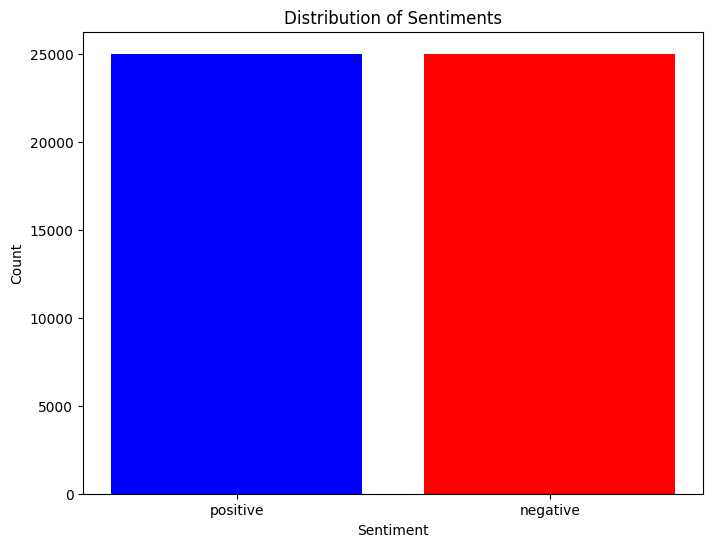

In [8]:
import matplotlib.pyplot as plt

# Data
sentiments = ['positive', 'negative']
counts = [25000, 25000]

# Create bar chart
plt.figure(figsize=(8, 6))
plt.bar(sentiments, counts, color=['blue', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments')
plt.show()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], y, test_size=0.2, random_state=42)


In [10]:
# Tokenization
max_words = 10000  # Vocabulary size
max_len = 100  # Max length of sequences
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')


In [11]:
vocab_size = len(tokenizer.word_index) + 1  # Add 1 to include padding in the vocabulary size


In [12]:
embedding_dim = 100  # Dimensionality of the embedding
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Download the GloVe embedding file
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

# Specify the correct path to the GloVe file
glove_file = 'glove.6B.100d.txt'
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        if word in tokenizer.word_index:
            idx = tokenizer.word_index[word]
            embedding_matrix[idx] = coefs

--2024-08-28 16:40:07--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-08-28 16:40:07--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-08-28 16:40:08--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten

# NN Model
nn_model = Sequential()
nn_model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
nn_model.add(Flatten())
nn_model.add(Dense(10, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))

# Compile and train the model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn_model.summary()
nn_model.fit(X_train_pad, y_train, epochs=10, validation_data=(X_test_pad, y_test))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │      18,640,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,640,700 (71.11 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 18,640,700 (71.11 MB)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.5341 - loss: 0.6808 - val_accuracy: 0.7436 - val_loss: 0.5191
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7829 - loss: 0.4649 - val_accuracy: 0.7555 - val_loss: 0.5096
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8223 - loss: 0.3920 - val_accuracy: 0.7648 - val_loss: 0.5017
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8404 - loss: 0.3510 - val_accuracy: 0.7605 - val_loss: 0.5243
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.8486 - loss: 0.3264 - val_accuracy: 0.7575 - val_loss: 0.5526
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8604 - loss: 0.3021 - val_accuracy: 0.7554 - val_loss: 0.5935
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8652 - loss: 0.2797 - val_accuracy: 0.7403 - val_loss: 0.6403
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8737 - loss: 0.26

In [20]:
from tensorflow.keras.layers import LSTM, Dropout

# LSTM Model
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
lstm_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile and train the model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.summary()
lstm_model.fit(X_train_pad, y_train, epochs=10, validation_data=(X_test_pad, y_test))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │      18,640,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,640,700 (71.11 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 18,640,700 (71.11 MB)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 127s 100ms/step - accuracy: 0.6061 - loss: 0.6581 - val_accuracy: 0.7348 - val_loss: 0.5880
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 134s 93ms/step - accuracy: 0.6602 - loss: 0.6193 - val_accuracy: 0.7788 - val_loss: 0.5045
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 147s 97ms/step - accuracy: 0.7617 - loss: 0.5184 - val_accuracy: 0.8149 - val_loss: 0.4185
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 122s 97ms/step - accuracy: 0.8023 - loss: 0.4380 - val_accuracy: 0.8313 - val_loss: 0.3913
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 142s 97ms/step - accuracy: 0.8107 - loss: 0.4163 - val_accuracy: 0.8302 - val_loss: 0.3882
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 148s 102ms/step - accuracy: 0.8145 - loss: 0.4140 - val_accuracy: 0.8414 - val_loss: 0.3661
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 144s 104ms/step - accuracy: 0.8245 - loss: 0.3924 - val_accuracy: 0.8430 - val_loss: 0.3605
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 134s 98ms/step - accurac

In [21]:
# Evaluate NN Model
nn_loss, nn_acc = nn_model.evaluate(X_test_pad, y_test)
print(f'NN Model Accuracy: {nn_acc:.2f}')

# Evaluate LSTM Model
lstm_loss, lstm_acc = lstm_model.evaluate(X_test_pad, y_test)
print(f'LSTM Model Accuracy: {lstm_acc:.2f}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7430 - loss: 0.7561
NN Model Accuracy: 0.74
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - accuracy: 0.8609 - loss: 0.3236
LSTM Model Accuracy: 0.86


In [35]:
import numpy as np

# Example statements to test
statements = ["very good movie", "terrible acting", "amazing plot", "not worth the time", "loved the visuals"]

# Step 1: Preprocess the input statements
# Tokenize the statements
tokens = tokenizer.texts_to_sequences(statements)

# Pad the sequences
padded_sequences = pad_sequences(tokens, maxlen=max_len)  # Use max_len instead of maxlen

# Step 2: Predict sentiment using both models
nn_predictions = nn_model.predict(padded_sequences)
lstm_predictions = lstm_model.predict(padded_sequences)

# Step 3: Decode predictions and print results
for i, statement in enumerate(statements):
    nn_sentiment = 'Positive' if nn_predictions[i] > 0.5 else 'Negative'
    lstm_sentiment = 'Positive' if lstm_predictions[i] > 0.5 else 'Negative'

    print(f"Statement: {statement}")
    print(f"  NN Model Prediction: {nn_sentiment}")
    print(f"  LSTM Model Prediction: {lstm_sentiment}")
    print()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
Statement: very good movie
  NN Model Prediction: Positive
  LSTM Model Prediction: Negative

Statement: terrible acting
  NN Model Prediction: Negative
  LSTM Model Prediction: Negative

Statement: amazing plot
  NN Model Prediction: Negative
  LSTM Model Prediction: Negative

Statement: not worth the time
  NN Model Prediction: Positive
  LSTM Model Prediction: Negative

Statement: loved the visuals
  NN Model Prediction: Negative
  LSTM Model Prediction: Negative

